# Fit and predict using pib features and logistic regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load data 

In [2]:
files_df = pd.read_pickle('../processed_data/files_df.pkl')
files_df.head()

,dir_name,file_name,path,patient,preictal,train,pib_3,pib_2,pib_1
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0,848777,1897922,511194
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0,1805838,1484367,216014
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0,1241170,1900609,284337
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0,1743604,1513067,231791
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0,2139217,1235885,187611


## Extract useful data

In [3]:
meta_df = files_df.set_index('file_name')
meta_df = meta_df.loc[:,'patient':]
meta_df.head()

,patient,preictal,train,pib_3,pib_2,pib_1
file_name,,,,,,
1_1.mat,1,-1,0,848777,1897922,511194
1_10.mat,1,-1,0,1805838,1484367,216014
1_100.mat,1,-1,0,1241170,1900609,284337
1_1000.mat,1,-1,0,1743604,1513067,231791
1_1001.mat,1,-1,0,2139217,1235885,187611


In [4]:
# Train data
X_train = meta_df[meta_df['train']==1]
y_train = meta_df[meta_df['train']==1]['preictal']
X_train = X_train.drop(['train','preictal'], axis=1)
display(X_train.head())
display(y_train.head())

,patient,pib_3,pib_2,pib_1
file_name,,,,
1_1000_0.mat,1,789192,2056416,481576
1_1001_0.mat,1,824351,1985675,485730
1_1002_0.mat,1,945059,2082889,396960
1_1003_0.mat,1,796860,2068275,432816
1_1004_0.mat,1,997601,1962371,409753


file_name
1_1000_0.mat    0
1_1001_0.mat    0
1_1002_0.mat    0
1_1003_0.mat    0
1_1004_0.mat    0
Name: preictal, dtype: int64

In [5]:
# Test data
X_test = meta_df[meta_df['train']==0]
X_test = X_test.drop(['train','preictal'], axis=1)
display(X_test.head())

,patient,pib_3,pib_2,pib_1
file_name,,,,
1_1.mat,1,848777,1897922,511194
1_10.mat,1,1805838,1484367,216014
1_100.mat,1,1241170,1900609,284337
1_1000.mat,1,1743604,1513067,231791
1_1001.mat,1,2139217,1235885,187611


## Define pipeline and cross validation model fitting

In [6]:
param_grid = {
    'classify__C': [.025,.05,.075,1,1.25],
    'classify__gamma': [4,6,8,10],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('standardize', StandardScaler()),
    ('classify', SVC())
])

cv_pipeline =  GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

In [7]:
%%time
cv_pipeline.fit(X=X_train, y=y_train)

CPU times: user 29.7 s, sys: 251 ms, total: 30 s
Wall time: 30.1 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__gamma': [4, 6, 8, 10], 'classify__C': [0.025, 0.05, 0.075, 1, 1.25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [8]:
print('{:.3%}'.format(cv_pipeline.best_score_))
print(cv_pipeline.best_params_)

60.364%
{'classify__gamma': 10, 'classify__C': 0.05}


In [9]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__C,param_classify__gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__C,classify__gamma
0,0.145248,0.042799,0.553053,0.628345,0.025,4,"{'classify__gamma': 4, 'classify__C': 0.025}",9,0.695697,0.618433,0.47117,0.658277,0.492293,0.608324,0.019186,0.002034,0.101233,0.021564,0.025,4
1,0.133989,0.041714,0.527606,0.667243,0.025,6,"{'classify__gamma': 6, 'classify__C': 0.025}",20,0.683340,0.681705,0.40917,0.643027,0.490308,0.676998,0.005004,0.005469,0.114995,0.017231,0.025,6


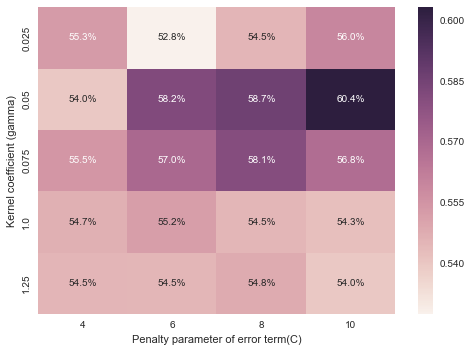

In [10]:
# Cross-validated performance heatmap
ax = plt.figure()
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__C', columns='classify__gamma')

ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Penalty parameter of error term(C)')
ax.set_ylabel('Kernel coefficient (gamma)');

## Use Optimal Hyperparameters to Output ROC Curve

In [13]:
def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

y_pred_train = cv_pipeline.decision_function(X_train)
metrics_train = get_threshold_metrics(y_train, y_pred_train)

file_name
1_1000_0.mat    0
1_1001_0.mat    0
1_1002_0.mat    0
1_1003_0.mat    0
1_1004_0.mat    0
1_1005_0.mat    0
1_1006_0.mat    0
1_1007_0.mat    0
1_1008_0.mat    0
1_1009_0.mat    0
1_100_0.mat     0
1_100_1.mat     1
1_1010_0.mat    0
1_1011_0.mat    0
1_1012_0.mat    0
1_1013_0.mat    0
1_1014_0.mat    0
1_1015_0.mat    0
1_1016_0.mat    0
1_1017_0.mat    0
1_1018_0.mat    0
1_1019_0.mat    0
1_101_0.mat     0
1_101_1.mat     1
1_1020_0.mat    0
1_1021_0.mat    0
1_1022_0.mat    0
1_1023_0.mat    0
1_1024_0.mat    0
1_1025_0.mat    0
               ..
3_978_0.mat     0
3_979_0.mat     0
3_97_0.mat      0
3_97_1.mat      1
3_980_0.mat     0
3_981_0.mat     0
3_982_0.mat     0
3_983_0.mat     0
3_984_0.mat     0
3_985_0.mat     0
3_986_0.mat     0
3_987_0.mat     0
3_988_0.mat     0
3_989_0.mat     0
3_98_0.mat      0
3_98_1.mat      1
3_990_0.mat     0
3_991_0.mat     0
3_992_0.mat     0
3_993_0.mat     0
3_994_0.mat     0
3_995_0.mat     0
3_996_0.mat     0
3_997_0.mat     0


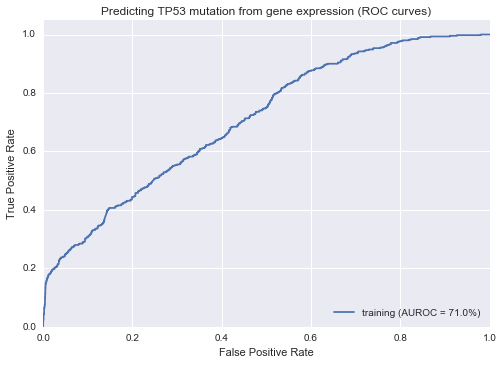

In [86]:
roc_df = metrics_train['roc_df']
plt.plot(roc_df.fpr, roc_df.tpr,
label='{} (AUROC = {:.1%})'.format('training', metrics_train['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Predict test ictal status and save as csv

In [88]:
y_pred_test = cv_pipeline.predict(X_test)
output_df = pd.DataFrame({'File':X_test.index.values, 'Class': y_pred_test})
output_df = output_df[['File','Class']]
output_df.to_csv('../submissions/submission_5.csv',index=False)
output_df.head()

,File,Class
0,1_1.mat,0
1,1_10.mat,0
2,1_100.mat,0
3,1_1000.mat,0
4,1_1001.mat,0
